## Model Evaluation Metrics


In [1]:
import os
from pathlib import Path
os.chdir(Path("..").resolve())  # if notebook is in notebooks/


In [2]:
import sys
sys.path.append(str(Path("src").resolve()))


In [3]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader

from dataset import FolderImageDataset, find_data_root, CLASS_NAMES
from model import build_resnet50

def eval_weights(weights_path: str):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data_root = find_data_root()

    test_ds = FolderImageDataset(data_root, split="Testing", img_size=224, train=False)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

    model = build_resnet50(num_classes=4, pretrained=False).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("=" * 80)
    print("Weights:", weights_path)
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))

# Compare both
eval_weights("runs/best_noaug.pt")
eval_weights("runs/best_aug.pt")


Weights: runs/best_noaug.pt
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.3600    0.5294       100
meningioma_tumor     0.7226    0.9739    0.8296       115
        no_tumor     0.7609    1.0000    0.8642       105
 pituitary_tumor     0.9538    0.8378    0.8921        74

        accuracy                         0.7995       394
       macro avg     0.8593    0.7929    0.7788       394
    weighted avg     0.8466    0.7995    0.7744       394

Confusion matrix (rows=true, cols=pred):
[[ 36  37  24   3]
 [  0 112   3   0]
 [  0   0 105   0]
 [  0   6   6  62]]
Weights: runs/best_aug.pt
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.3000    0.4615       100
meningioma_tumor     0.6706    0.9913    0.8000       115
        no_tumor     0.7744    0.9810    0.8655       105
 pituitary_tumor     0.9836    0.8108    0.8889        74

        accuracy                         0.7792       394
       macr

In [4]:
if Path("runs").exists():
    print("contents of runs:", list(Path("runs").iterdir()))


contents of runs: [WindowsPath('runs/best.pt'), WindowsPath('runs/best_aug.pt'), WindowsPath('runs/best_noaug.pt'), WindowsPath('runs/history_aug.csv'), WindowsPath('runs/history_noaug.csv')]


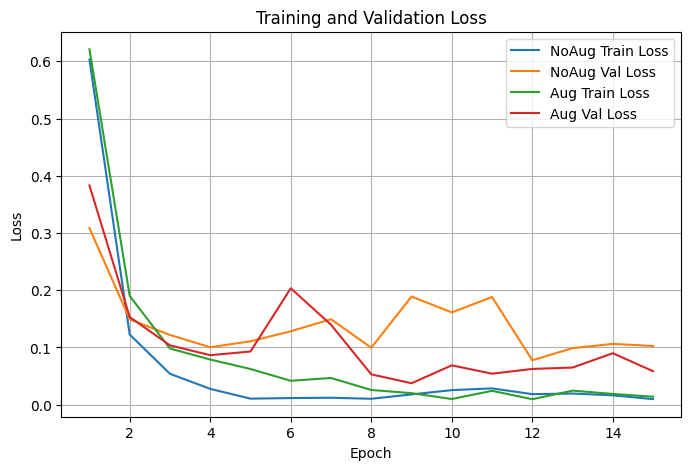

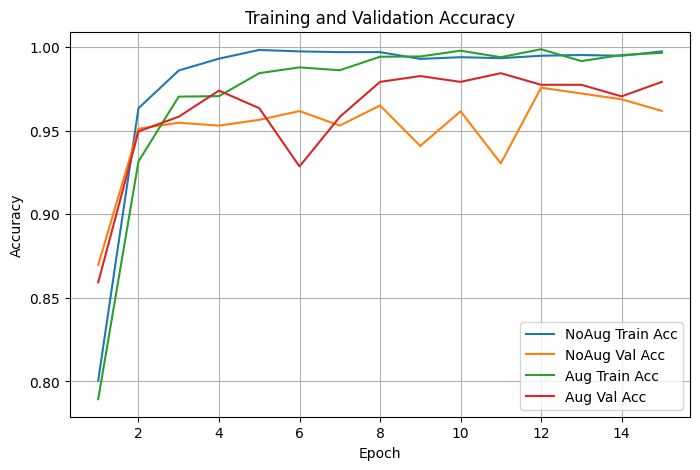

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load histories
noaug = pd.read_csv(Path("runs/history_noaug.csv"))
aug   = pd.read_csv(Path("runs/history_aug.csv"))

# ---- Loss curves ----
plt.figure(figsize=(8,5))
plt.plot(noaug["epoch"], noaug["train_loss"], label="NoAug Train Loss")
plt.plot(noaug["epoch"], noaug["val_loss"],   label="NoAug Val Loss")
plt.plot(aug["epoch"],   aug["train_loss"],   label="Aug Train Loss")
plt.plot(aug["epoch"],   aug["val_loss"],     label="Aug Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- Accuracy curves ----
plt.figure(figsize=(8,5))
plt.plot(noaug["epoch"], noaug["train_acc"], label="NoAug Train Acc")
plt.plot(noaug["epoch"], noaug["val_acc"],   label="NoAug Val Acc")
plt.plot(aug["epoch"],   aug["train_acc"],   label="Aug Train Acc")
plt.plot(aug["epoch"],   aug["val_acc"],     label="Aug Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
